In [1]:
import numpy as np

import forward.common as common
import forward.homogeneous_semi_inf as hsi
import utils.noise as noise
import inverse.fit_homogeneous_semi_inf as fhsi
import inverse.mbl_homogeneous_semi_inf as mbl
import matplotlib.pyplot as plt

# Generate some curves

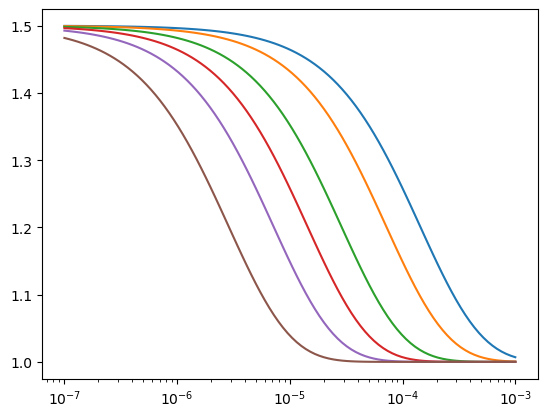

In [19]:
tau = np.logspace(-7, -3, 100)
lambda0 = 785
mua = 0.01
musp = 10
rho = 2
n = 1.4
db = [1e-9, 2e-9, 5e-9, 1e-8, 2e-8, 5e-8]
v_ms = [1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4]
beta = 0.5
g1_norm = np.zeros((len(tau), len(db)))
g2_norm = np.zeros((len(tau), len(db)))
for i in range(len(db)):
    msd = common.msd_brownian(tau, db[i])
    g1_norm[:, i] = hsi.g1_norm(msd, mua, musp, rho, n, lambda0)

g2_norm = 1 + beta * g1_norm**2
plt.semilogx(tau, g2_norm)
plt.show()

# Add noise

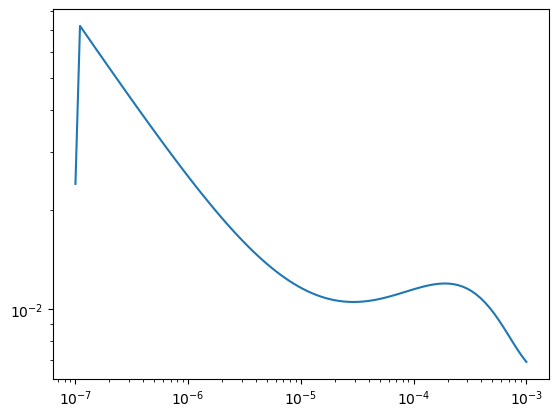

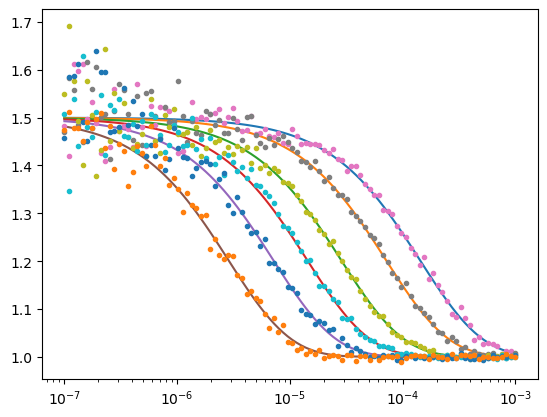

In [23]:
# Look at the noise model
sigma = noise.sigma_g2_norm(tau, t_integration=1, countrate=10e4, beta=0.5, tau_c=200e-6, n_speckle=3)
plt.loglog(tau, sigma)
plt.show()

noise_adder = noise.NoiseAdder(
    g2_norm=g2_norm,
    tau=tau,
    t_integration=1,
    countrate=8e4,
    beta=0.5,
    n_speckle=3,
    mua=mua,
    musp=musp,
    db=np.array(db),
    lambda0=lambda0
)

g2_norm_noisy = noise_adder.add_noise()
plt.semilogx(tau, g2_norm)
plt.semilogx(tau, g2_norm_noisy, linestyle='none', marker='.')
plt.show()

In [ ]:
#beta_calculator =  fhsi.BetaCalculator(mode="fixed", beta_fixed=0.50)
beta_calculator = fhsi.BetaCalculator(mode="fit", beta_init=0.48, beta_bounds=(0.45, 0.6))
msd_model = fhsi.MSDModel(model_name="brownian", param_init={"db": 1e-8}, param_bounds={"db": (0, None)})
#msd_model = fhsi.MSDModel(model_name="ballistic", param_init={"v_ms": 1e-4}, param_bounds={"v_ms": (0, None)})
#msd_model = fhsi.MSDModel(model_name="hybrid", param_init={"db": 1e-8, "v_ms": 1e-4}, param_bounds={"db": (0, None), "v_ms": (0, None)})
fitter = fhsi.FitHomogeneousSemiInf(
    tau,
    g2_norm,
    mua,
    musp,
    rho,
    n,
    lambda0,
    msd_model,
    beta_calculator,
    tau_lims_fit=(1e-7, 1e-3),
    g2_lim_fit=1.3,
    plot_interval=100
)

fitted_data = fitter.fit()

In [ ]:
fitted_data

In [ ]:
mbl_analyzer = mbl.MBLHomogeneousSemiInf(
    tau,
    g2_norm,
    mua,
    musp,
    rho,
    n,
    lambda0,
    g2_norm[:, 0],
    mua,
    musp,
    db[0]
)

db_calculated = mbl_analyzer.fit()
plt.loglog(tau, db_calculated)
plt.show()